In [1]:
import model_STN
import Generator_STN
import HeadCT_motion_correction_PAR.Data_processing as dp
import HeadCT_motion_correction_PAR.functions_collection as ff
from HeadCT_motion_correction_PAR.Build_lists import Build_list
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform

import os
import numpy as np
import nibabel as nb
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2

2022-12-15 23:40:28.173318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(25, 128, 128, 15, 1)


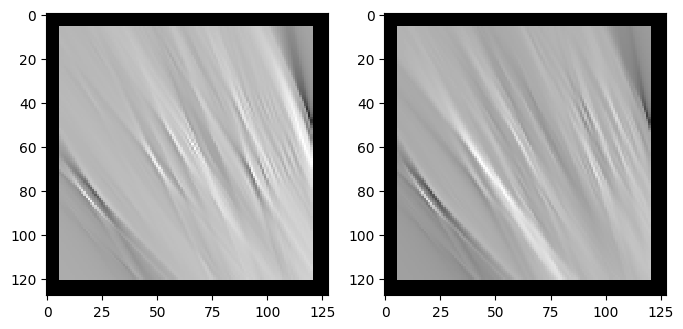

In [2]:
trial_name = 'STN_play'
data_sheet = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/Patient_list/Patient_list_train_test_PAR_downsampled_dim128_slice0-15.xlsx')
b = Build_list.Build(data_sheet)
batch_list = [0]
_, _, _, _, _, _, _, _, _, _, y_motion_param_predict, x_par_image_predict, y_image_predict = b.__build__(batch_list = batch_list)

image = np.expand_dims(np.load(x_par_image_predict[0],allow_pickle = True),axis = -1)
print(image.shape)
plt.figure(figsize = (8,4))
plt.subplot(121); plt.imshow(image[10,:,:,5,0], 'gray')
plt.subplot(122); plt.imshow(image[10,:,:,10,0], 'gray')


In [3]:
# build model
m = ['3','008']
model_file = ff.find_all_target_files(['*'+m[1]+'.hdf5'],os.path.join('/mnt/mount_zc_NAS/motion_correction/model',trial_name,'models','batch_'+str(m[0])))
model_file = model_file[0]
input_shape = (25,) + (128,128,15) + (1,)
model_inputs = [Input(input_shape)]
model_outputs=[]
tx_yCP,tx_ys, ty_yCP, ty_ys, theta_yCP, theta_ys, matrix, final_image = model_STN.get_model(input_shape ,dimension = 3,activate = True, batch_norm = True, crop_STN = True)(model_inputs[0])
model_outputs += [tx_yCP]
model_outputs += [tx_ys]
model_outputs += [ty_yCP]
model_outputs += [ty_ys]
model_outputs += [theta_yCP]
model_outputs += [theta_ys]
model_outputs += [matrix]
model_outputs += [final_image]
  
model = Model(inputs = model_inputs,outputs = model_outputs)
    
model.load_weights(model_file)

(None, 25, 128, 128, 15, 1)


2022-12-15 23:40:34.687649: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 23:40:34.687809: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-15 23:40:34.725115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 23:40:34.726149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2022-12-15 23:40:34.726167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-15 23:40:34.726222: I tensorflow/stream_executor/platform/defau

In [15]:
# get DL prediction
datagen = Generator_STN.DataGenerator(np.asarray([x_par_image_predict[0]]),np.asarray([y_motion_param_predict[0]]),np.asarray([y_image_predict[0]]),
                                    patient_num = 1, 
                                    batch_size = 1, 
                                    input_dimension = (25,128,128,15),
                                    output_vector_dimension = (4,),
                                    output_img_dimension = (90,90,2),
                                    shuffle = False,
                                    add_noise = False,
                                    noise_sigma = 0,
                                    seed = 10)
tx,tx_ys, ty, ty_ys, theta, theta_ys, matrix,  final_image = model.predict_generator(datagen, verbose = 1, steps = 1,)
print(final_image.shape)

1/1 [==============================] - 0s 319ms/step
(1, 90, 90, 2, 1)


In [16]:
print('tx: ', tx)
print('tx_ys ', tx_ys[0][0:10])
print('ty: ', ty)
print('ty_ys ', ty_ys[0][0:10])
print('theta: ', theta)
print('theta_ys ', theta_ys[0][0:10])
print('matrix shape: ',matrix.shape)
translation = np.array([[1,0, -ty_ys[0][9]], [0,1,-tx_ys[0][9]], [0,0,1]]) # STN has opposite coordinate as ours
rotation = np.array([[math.cos(theta_ys[0][9]), -math.sin(theta_ys[0][9]), 0 ], [math.sin(theta_ys[0][9]), math.cos(theta_ys[0][9]), 0], [0,0,1]])
print('translation: ', translation )
print('rotation: ', rotation )
print('multiply: ', tf.linalg.matmul(tf.convert_to_tensor(rotation), tf.convert_to_tensor(translation)))
print('second matrix: ',matrix[0,9,:,:])

tx:  [[ 0.02149107  0.00603126  0.03118501 -0.02782808]]
tx_ys  [0.00383587 0.00816363 0.01252922 0.0164786  0.01955772 0.02131251
 0.02109545 0.01869779 0.01503649 0.01106465]
ty:  [[-0.0050249   0.00023605  0.01479391  0.00263695]]
ty_ys  [-0.00091458 -0.00196608 -0.00302811 -0.00397429 -0.00467821 -0.00501349
 -0.00493041 -0.00456073 -0.00392369 -0.00303142]
theta:  [[0.00086347 0.03248698 0.03012013 0.00381342]]
theta_ys  [-0.00019258 -0.00079463 -0.00142819 -0.00171526 -0.00127787  0.00026196
  0.00344442  0.00844495  0.01449816  0.02080839]
matrix shape:  (1, 25, 2, 3)
translation:  [[ 1.          0.          0.00303142]
 [ 0.          1.         -0.01106465]
 [ 0.          0.          1.        ]]
rotation:  [[ 0.99978351 -0.02080689  0.        ]
 [ 0.02080689  0.99978351  0.        ]
 [ 0.          0.          1.        ]]
multiply:  tf.Tensor(
[[ 0.99978351 -0.02080689  0.00326099]
 [ 0.02080689  0.99978351 -0.01099918]
 [ 0.          0.          1.        ]], shape=(3, 3), dt

Compare DL pictures (made by spatial transformer) vs. our pictures (made by applying DL-predicted MVF to each PAR)

In [10]:
j = 20
array_1 = np.squeeze(array) * 1000
I = image[j,:,:,10,0]

t = [-tx_ys[0][j], -ty_ys[0][j]]
t = [tt / 2 * 128  for tt in t] 
print(t)
r = -float(theta_ys[0][j]) 
print(r / np.pi * 180)
s = [1,1]

translation,rotation,scale,transformation_matrix = transform.generate_transform_matrix(t,r,s,I.shape)
transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
img_t = transform.apply_affine_transform(I, transformation_matrix, 3 , cval = np.min(I))

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(I, 'gray')
plt.subplot(132); plt.imshow(array_1[j,:,:,1], 'gray')
plt.subplot(133); plt.imshow(img_t[19:109, 19:109], 'gray')  # second and third image should be the same
print(img_t[19:109, 19:109][40,20])
print(array_1[j,40,20,1])


NameError: name 'array' is not defined

(90, 90, 2) 2047.2214
64.66655515961538
-980.4157 -930.9702239833621


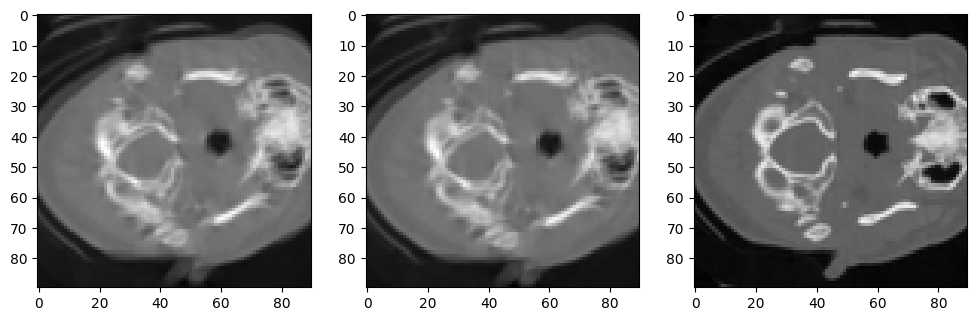

In [24]:
final_t = np.zeros((25,90,90))

for j in range(0,25):
    I = image[j,:,:,10,0]
    t = [-tx_ys[0][j], -ty_ys[0][j]]
    t = [tt /2 * 128 for tt in t]
    r = -float(theta_ys[0][j])

    translation = np.array([[1,0, t[0]], [0,1,t[1]], [0,0,1]]) # STN has opposite coordinate as ours
    rotation = np.array([[math.cos(r), -math.sin(r), 0 ], [math.sin(r), math.cos(r), 0], [0,0,1]])

    transformation_matrix = np.dot(rotation, translation)
    # translation,rotation,scale,transformation_matrix = transform.generate_transform_matrix(t,r,s,I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_t = transform.apply_affine_transform(I, transformation_matrix, 1, cval = np.min(I) )
    final_t[j,:,:] = img_t[19:109, 19:109]
final_t = np.sum(final_t,axis = 0) / 25

# check final image
final = np.squeeze(final_image) * 1000
print(final.shape, np.max(final))

# final ground truth
y_img = nb.load(y_image_predict[0]).get_fdata()
gt = y_img[(y_img.shape[0]//2 - 45):(y_img.shape[0]//2 + 45), (y_img.shape[1]//2 - 45):(y_img.shape[1]//2 + 45),[5,10]]

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(final[:,:,1], 'gray')
plt.subplot(132); plt.imshow(final_t, 'gray')
plt.subplot(133); plt.imshow(gt[:,:,1], 'gray')

mae1,_,_,_,_,_ = ff.compare(final[:,:,1], final_t, -100)
print(mae1)
print(final[41,60,1],final_t[41,60])

use STN to do transformation

In [6]:
import model_components as compo
final_tt = np.zeros((25,90,90,15))

for j in range(0,25):
    I = image[j,:,:,:,:]
    I = I[np.newaxis,...]
    I = np.transpose(I,[3,0,1,2,4])
    r = float(theta_ys[0][j])

    translation = np.array([[1,0, -ty_ys[0][j]], [0,1,-tx_ys[0][j]], [0,0,1]]) # STN has opposite coordinate as ours
    rotation = np.array([[math.cos(r), -math.sin(r), 0 ], [math.sin(r), math.cos(r), 0], [0,0,1]])

    transformation_matrix = np.dot(rotation, translation)
    matrix = transformation_matrix[0:2,:]
    a = [compo.BilinearInterpolation(128,128)([ii,matrix]) for ii in I]
    a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
    a = np.squeeze(a)
    final_tt[j,:,:,:] = a[19:109, 19:109,:]
final_tt = np.sum(final_tt,axis = 0) / 25

(90, 90, 2) 2047.2214
0.21556990573621262
24.807657 24.884967575073244


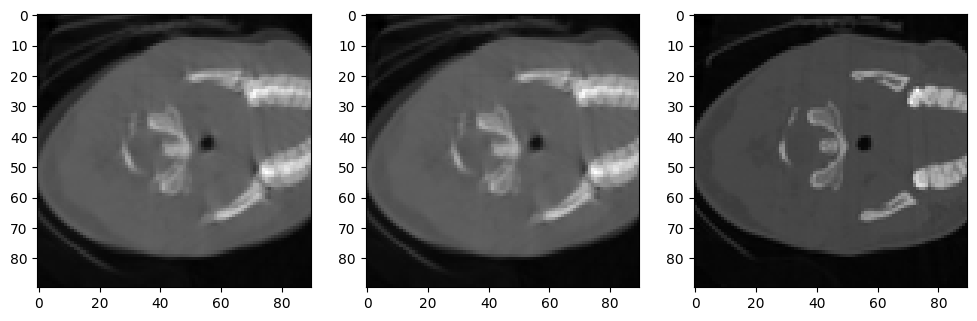

In [59]:
# check final image
final = np.squeeze(final_image) * 1000
print(final.shape, np.max(final))

# final ground truth
y_img = nb.load(y_image_predict[0]).get_fdata()
gt = y_img[(y_img.shape[0]//2 - 45):(y_img.shape[0]//2 + 45), (y_img.shape[1]//2 - 45):(y_img.shape[1]//2 + 45),[5,10]]

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(final[:,:,0], 'gray')
plt.subplot(132); plt.imshow(final_tt[:,:,5], 'gray')
plt.subplot(133); plt.imshow(gt[:,:,0], 'gray')

mae1,_,_,_,_,_ = ff.compare(final[:,:,0], final_tt[:,:,5], -100)
print(mae1)
print(final[41,60,0],final_tt[41,60,5])

In [7]:
# load data

# motion parameters:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000002/MO001A000002/random_3/motion_parameters.npy')
p = np.load(file_name,allow_pickle = True)
# PAR:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/PAR_2D_spline','MO101701M000002/MO001A000002/random_3/slice_0_to_15/ds/PARs_ds_crop.npy')
par = np.load(file_name,allow_pickle = True)


In [23]:
downsample = True
tx= p[0,:][0]
ty= p[2,:][0]
theta = p[4,:][0]
spline_x = transform.interp_func(np.linspace(0,1,5),np.asarray(tx)); tx_25 = [spline_x(l) for l in np.linspace(0.04, 1,25 )]
spline_y = transform.interp_func(np.linspace(0,1,5), np.asarray(ty)); ty_25 = [spline_y(l) for l in np.linspace(0.04, 1,25 )]
spline_r = transform.interp_func(np.linspace(0,1,5), np.asarray(theta)); r_25 = [spline_r(l) for l in np.linspace(0.04, 1,25 )]

d = [1 if downsample == False else 2][0]
par_stn = np.copy(par)
for j in range(0,25):
    I = par[j,:,:,:]
    I = np.expand_dims(I[np.newaxis,...],axis = -1)
    I = np.transpose(I,[3,0,1,2,4])

    rr = float(r_25[j][0])
    translation = np.array([[1,0, -ty_25[j][0] / d], [0,1,-tx_25[j][0]/d ], [0,0,1]]) # STN has opposite coordinate as ours
    rotation = np.array([[math.cos(rr), -math.sin(rr), 0 ], [math.sin(rr), math.cos(rr), 0], [0,0,1]])


    transformation_matrix = np.dot(rotation, translation)
    matrix = transformation_matrix[0:2,:]
    
    a = [compo.BilinearInterpolation(128,128)([ii,matrix]) for ii in I]
    a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
    par_stn[j,:,:,:] = np.squeeze(a)
par_stn = np.sum(par_stn,axis = 0) / 25

In [22]:
tx_25[10]

array([4.84055628])